In [1]:
import torch
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn.functional as F
from torch_geometric_temporal.dataset import METRLADatasetLoader, ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.attention import ASTGCN, STConv
from torch_geometric_temporal.nn.recurrent import A3TGCN, DCRNN

pt_version = torch.__version__
print(pt_version)

1.13.1+cu117


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [4]:
RAW_URL = "https://raw.githubusercontent.com/Vishesh-Mittal/CongestionControl-GNN/ccgnn_dataset/"

step_size = 1 #timestep = step_size * 15
history_size = 4 #timesteps to be considered as history
num_of_vertices = 20

In [5]:
node_data = pd.read_csv(RAW_URL + "DIVE/DIVE_speed.csv", header = None)
edge_features = pd.read_csv(RAW_URL + "DIVE/DIVE_adj.csv", header = None)

In [6]:
stdScaler = StandardScaler()

node_data_array = np.array(node_data)
stdScaler.fit(node_data_array)
node_data_array = stdScaler.transform(node_data_array)
node_data_array

array([[-1.10285713, -1.21650587, -1.30865248, ...,  0.37969456,
         1.22310742,  0.22232829],
       [ 0.23942648, -1.11746493, -1.30865248, ...,  0.37969456,
         1.22310742,  0.22232829],
       [-0.49057164, -0.55538925, -0.43099249, ...,  0.37969456,
         1.22310742,  0.22232829],
       ...,
       [-0.82965884, -1.23403243, -0.96919997, ...,  0.37969456,
         0.0775089 ,  0.22232829],
       [-0.64081302, -0.78683407, -0.61415733, ...,  0.37969456,
        -1.06808963,  0.22232829],
       [-0.44243547, -0.50638527, -0.24417226, ...,  0.37969456,
         0.0775089 ,  0.22232829]])

In [7]:
node_data_array.shape

(1345, 20)

In [8]:
#to be uploaded
edges = [
    (0, 0),(0, 1),(0, 4),(0, 10),(0, 15),(0, 17),
    (1, 0),(1, 1),(1, 2),(1, 4),
    (2, 1),(2, 2),(2, 3),(2, 12),
    (3, 2),(3, 3),(3, 7),(3, 9),(3, 12),
    (4, 0),(4, 1),(4, 4),(4, 6),(4, 18),
    (5, 5),(5, 10),(5, 11),(5, 12),
    (6, 6),(6, 7),(6, 18),
    (7, 3),(7, 6),(7, 7),
    (8, 8),(8, 9),(8, 19),
    (9, 3),(9, 8),(9, 9),
    (10, 0),(10, 5),(10, 10),(10, 11),
    (11, 11),(11, 5),(11, 10),(11, 13),
    (12, 3),(12, 5),(12, 12),
    (13, 11),(13, 13),
    (14, 14),(14, 17),
    (15, 0),(15, 15),
    (16, 16),(16, 17),(16, 18),(16, 19),
    (17, 0),(17, 14),(17, 16),
    (18, 4),(18, 6),(18, 16),(18, 18),
    (19, 8),(19, 16),(19, 19)
]
edges = np.array(edges)
edges.shape

(71, 2)

In [9]:
#Required data

xs = []
edge_indices = []
ys = []
y_indices = []
edge_attr = []

#temporaries
edge_index = []
edge_feat = []

for edge in edges:
    edge_index.append(list(edge))
    edge_feat.append(edge_features[edge[0]][edge[1]])

final_edge_index = np.transpose(edge_index)

for index in range(len(node_data_array) - (history_size + step_size + 1)):

    node_features = node_data_array[index : index + history_size]
    subsequent_node_features = node_data_array[index + history_size + step_size]

    node_feat_transpose = np.transpose(node_features)
    node_feat_transpose_reshaped = node_feat_transpose.reshape(20,1,4)
    #node_feat_transpose_reshaped = node_feat_transpose #For DCRNN (Temp)
    subsequent_node_feat_transpose = np.transpose(subsequent_node_features)
    subsequent_node_feat_transpose_reshaped = subsequent_node_feat_transpose.reshape(20, 1)
    
    xs.append(node_feat_transpose_reshaped)
    ys.append(subsequent_node_feat_transpose_reshaped)
    edge_indices = final_edge_index #static
    edge_attr = edge_feat #static

xs = np.array(xs)
ys = np.array(ys)
edge_indices = np.array(edge_indices)
edge_attr = np.array(edge_attr)

In [10]:
print(f"""
      X feature shape: {xs.shape} \n
      Edge index shape: {edge_indices.shape} \n
      Edge attribute shape: {edge_attr.shape} \n 
      Labels shape: {ys.shape} \n
      """)


      X feature shape: (1339, 20, 1, 4) 

      Edge index shape: (2, 71) 

      Edge attribute shape: (71,) 
 
      Labels shape: (1339, 20, 1) 

      


In [11]:
i = 0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge attribute shape: {edge_attr[i].shape} \n 
      Labels shape: {ys[i].shape} \n
      """)

Example of graph snapshot 0: 

      Node feature shape: (20, 1, 4) 

      Edge index shape: (71,) 

      Edge attribute shape: () 
 
      Labels shape: (20, 1) 

      


In [12]:
dive_dataset = StaticGraphTemporalSignal(edge_indices, edge_attr, xs, ys)
m = next(iter(dive_dataset))
m

Data(x=[20, 1, 4], edge_index=[2, 71], edge_attr=[71], y=[20, 1])

In [13]:
i = 0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {dive_dataset[i].x.shape} \n
      Edge index shape: {dive_dataset[i].edge_index.shape} \n
      Edge attribute shape: {dive_dataset[i].edge_attr.shape} \n 
      Labels shape: {dive_dataset[i].y.shape} \n
      """)

Example of graph snapshot 0: 

      Node feature shape: torch.Size([20, 1, 4]) 

      Edge index shape: torch.Size([2, 71]) 

      Edge attribute shape: torch.Size([71]) 
 
      Labels shape: torch.Size([20, 1]) 

      


<AxesSubplot:>

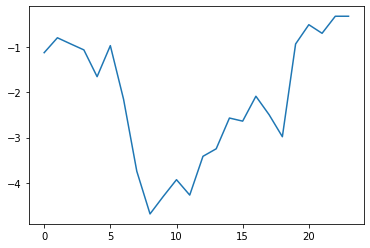

In [14]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
# sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dive_dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [15]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dive_dataset, train_ratio=0.8)
#train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  1071
Number of test buckets:  268
